In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
import lightgbm as lgb

In [2]:
weather = pd.read_csv('data/weather_v2.csv')
target = pd.read_csv('data/target_v2.csv')

/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (25) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# 2. 모델 구축 시 사용할 지점 및 기상 속성 선정 과정

## 사용 지점 (4곳)
- 제주, 고산, 성산, 서귀포 (ASOS 지점)

## 선정 이유
- 전국적으로 ASOS에서 관측한 기온이 공식으로 인정 받기 때문에 ASOS 기온만 사용해볼 것이다.
출처: https://www.hankyung.com/society/article/201807242843Y

- 사용 기상 속성
    - 제주: 기온
    - 고산: 기온
    - 성산: 기온
    - 서귀포: 기온

## 선정 이유
- 기온은 결측값이 가장 적음과 동시에, smp 및 supply와의 상관관계도 기타 속성에 비해 강한 편이다

In [ ]:
# 결측치 확인
import missingno as msno
msno.matrix(weather)

In [4]:
weather['date'] = weather['datetime'].apply(lambda x : x[:10])
weather_mean = weather.groupby('date').mean().reset_index(drop = True)

In [ ]:
# 평균 상관관계 확인 
pd.concat([target, weather_mean], axis = 1).corr().loc['smp_max':'supply','area':].abs().mean().sort_values(ascending = False).head(10)

# 3. 데이터 전처리
## target
- target의 date에서 년, 월, 일, 요일을 찾아 추가


## weather
- ASOS 지역의 기온만을 사용
- 기온는 지역별 기온의 중앙값만을 사용
- 선정된 시간별 기온에서 그 날의 최소기온, 최고기온, 평균기온를 찾아 target에 추가

In [5]:
target['date'] = pd.to_datetime(target['date'])

target['year'] = target['date'].dt.year
target['month'] = target['date'].dt.month
target['day'] = target['date'].dt.day
target['dayofweek'] = target['date'].dt.dayofweek

In [6]:
target.head()

,date,smp_max,smp_min,smp_mean,supply,year,month,day,dayofweek
0,2018-02-01,150.65,116.84,132.71,87.47,2018,2,1,3
1,2018-02-02,163.86,116.84,134.19,86.64,2018,2,2,4
2,2018-02-03,164.07,116.85,131.39,88.28,2018,2,3,5
3,2018-02-04,171.00,115.76,131.89,86.14,2018,2,4,6
4,2018-02-05,170.34,123.89,137.96,90.63,2018,2,5,0


In [7]:
weather = weather[weather['station'] == 'ASOS']

In [8]:
weather['datetime'] = pd.to_datetime(weather['datetime'])
weather = weather.loc[:,'area':'temp']

In [9]:
weather_list = []
for area in weather['area'].unique():
    weather_list.append(weather[weather['area']==area].copy())
    
for i, area in enumerate(weather['area'].unique()):
    weather_list[i].drop(['area'], axis=1, inplace=True)
    weather_list[i].columns = ['datetime', str(area)+'_temp']

In [10]:
start = '2018-02-01'
end = '2020-05-18'
hourly_temperature = pd.DataFrame(columns = ['datetime'])
date_range = pd.date_range(start, end, freq='H')
hourly_temperature['datetime'] = date_range

for d in weather_list:
    hourly_temperature  = hourly_temperature.merge(d, how='outer')
hourly_temperature['median'] = hourly_temperature.median(axis=1)
hourly_temperature = hourly_temperature.loc[:,['datetime', 'median']]
hourly_temperature.columns = ['date', 'temperature']

In [11]:
# 결측치는 1시간 후 온도로 처리
hourly_temperature['temperature'][hourly_temperature['temperature'].isna()] = hourly_temperature.shift(-1)['temperature'][hourly_temperature['temperature'].isna()]

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
start = '2018-02-01'
end = '2020-05-18'

daily_temperature = pd.DataFrame(columns = ['date'])
date_range = pd.date_range(start, end, freq='D')
daily_temperature['date'] = date_range

In [13]:
for d in range(daily_temperature.shape[0]):
    for h in range(24):
        daily_temperature.loc[d, 'temp_h'+str(h)] = hourly_temperature['temperature'][d*24:d*24+24][d*24+h]

In [14]:
daily_temperature['temp_max'] = daily_temperature.loc[:,'temp_h0':].max(axis=1)
daily_temperature['temp_min'] = daily_temperature.loc[:,'temp_h0':].min(axis=1)
daily_temperature['temp_mean'] = daily_temperature.loc[:,'temp_h0':].mean(axis=1)

In [15]:
daily_temperature.head()

,date,temp_h0,temp_h1,temp_h2,temp_h3,temp_h4,temp_h5,temp_h6,temp_h7,temp_h8,...,temp_h17,temp_h18,temp_h19,temp_h20,temp_h21,temp_h22,temp_h23,temp_max,temp_min,temp_mean
0,2018-02-01,3.80,3.80,3.95,3.75,3.35,3.45,3.6,3.65,3.70,...,5.00,4.25,4.15,4.00,3.75,3.40,3.3,5.95,3.30,4.298077
1,2018-02-02,3.20,2.85,2.75,2.60,2.60,2.70,2.6,2.45,2.55,...,4.10,3.85,3.95,3.95,3.85,3.95,4.0,5.25,2.45,3.576923
2,2018-02-03,3.90,4.00,3.80,3.70,3.35,2.75,2.9,1.35,1.55,...,0.30,0.20,0.25,-0.20,-0.50,-0.30,-0.2,4.00,-0.50,1.457692
3,2018-02-04,-0.65,-1.20,-1.35,-0.70,-1.65,-1.55,-1.4,-2.05,-1.60,...,-0.80,-1.00,-0.65,-1.20,-1.00,-1.30,-1.2,0.30,-2.05,-1.000000
4,2018-02-05,-0.95,-1.70,-1.45,-1.15,-0.95,-0.60,-0.2,-0.25,-0.70,...,1.45,1.20,0.10,0.20,0.55,0.15,-0.7,2.05,-1.70,0.015385


In [16]:
target['temp_max'] = daily_temperature['temp_max']
target['temp_min'] = daily_temperature['temp_min']
target['temp_mean'] = daily_temperature['temp_mean']

In [17]:
target

,date,smp_max,smp_min,smp_mean,supply,year,month,day,dayofweek,temp_max,temp_min,temp_mean
0,2018-02-01,150.65,116.84,132.71,87.47,2018,2,1,3,5.95,3.30,4.298077
1,2018-02-02,163.86,116.84,134.19,86.64,2018,2,2,4,5.25,2.45,3.576923
2,2018-02-03,164.07,116.85,131.39,88.28,2018,2,3,5,4.00,-0.50,1.457692
3,2018-02-04,171.00,115.76,131.89,86.14,2018,2,4,6,0.30,-2.05,-1.000000
4,2018-02-05,170.34,123.89,137.96,90.63,2018,2,5,0,2.05,-1.70,0.015385
...,...,...,...,...,...,...,...,...,...,...,...,...
833,2020-05-14,193.28,66.78,100.46,62.70,2020,5,14,3,22.35,14.95,18.942308
834,2020-05-15,198.23,61.81,102.38,64.91,2020,5,15,4,21.50,18.40,19.605769
835,2020-05-16,220.91,88.50,121.19,61.75,2020,5,16,5,19.05,15.75,17.628846
836,2020-05-17,207.75,65.78,116.82,61.55,2020,5,17,6,20.35,14.30,17.030769


# 4. 탐색적 자료분석

In [ ]:
plt.rcParams['figure.figsize'] = [12, 4]
plt.plot(target.loc[:, 'date'], target.loc[:, 'smp_max'], label='smp_max')
plt.plot(target.loc[:, 'date'], target.loc[:, 'smp_min'], label='smp_min')
plt.plot(target.loc[:, 'date'], target.loc[:, 'smp_mean'], label='smp_mean')
plt.plot(target.loc[:, 'date'], target.loc[:, 'supply'], label='supply')
plt.ylim(0,300)
plt.legend()
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [12, 4]
plt.plot(target.loc[:, 'date'], target.loc[:, 'supply'], label='supply')
plt.plot(target.loc[:, 'date'], target.loc[:, 'temp_mean'], label='temp_mean')
plt.legend()
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [12, 4]
plt.plot(target.loc[:334, 'date'], target.loc[:334, 'supply'], label='supply')
plt.plot(target.loc[:334, 'date'], target.loc[:334, 'temp_mean'], label='temp_mean')
plt.legend()
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [12, 4]
plt.scatter(target.loc[:334, 'temp_mean'], target.loc[:334, 'supply'], label='supply')
plt.legend()
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [12, 4]
plt.scatter(target.loc[:334, 'temp_mean'] - 19, target.loc[:334, 'supply'], label='supply')
plt.legend()
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [12, 4]
plt.plot(target.loc[:, 'date'], target.loc[:, 'smp_mean'], label='smp_mean')
plt.plot(target.loc[:, 'date'], target.loc[:, 'temp_mean'], label='temp_mean')
plt.legend()
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [15, 13]
sns.heatmap(target.corr(), annot=True)

In [ ]:
target

In [ ]:
plt.rcParams['figure.figsize'] = [15, 1]
for m in range(1, 13):
    sns.heatmap(target[target['date'].dt.month == m].corr().loc[['supply'],['month', 'day', 'dayofweek', 'temp_max', 'temp_min', 'temp_mean']], annot=True)
    plt.title('month : '+ str(m))
    plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [15, 1]
for m in range(1, 13):
    sns.heatmap(target[target['date'].dt.month == m].corr().loc[['smp_max'],'supply':], annot=True)
    plt.title('month : '+ str(m))
    plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [15, 1]
for m in range(1, 13):
    sns.heatmap(target[target['date'].dt.month == m].corr().loc[['smp_min'],'supply':], annot=True)
    plt.title('month : '+ str(m))
    plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [15, 1]
for m in range(1, 13):
    sns.heatmap(target[target['date'].dt.month == m].corr().loc[['smp_mean'],'supply':], annot=True)
    plt.title('month : '+ str(m))
    plt.show()

# 5. 모델 학습 및 검증
- lgbm을 이용하여 2가지 모델 작성

 
- 1) 과거 정보를 이용해 supply, 기상정보를 예측하는 모델 (시계열 모델)

    - 2) supply, 기상정보를 이용하여 smp를 예측하는 모델 (상관관계 모델)

- 1)의 모델을 이용해 supply, 기상정보를 예측한 후 2)의 모델로 smp를 예측

In [20]:
params = {
    'metric': 'mae',
    'seed':7777
    }

def create_model(train, val):

    model = lgb.train(params, d_train, 1000, d_val, verbose_eval=1000, early_stopping_rounds=100)
    
#     plt.rcParams['figure.figsize'] = [6, 4]
#     plt.plot(np.array(y_val), '.-', label='y_val')
#     plt.plot(model.predict(x_val), '.-', label='y_pred')
#     plt.title(str(future)+'days later')
#     plt.legend()
#     plt.show()

    return model

In [21]:
def trans(dataset, start_index, end_index, past, future, x_columns, y_columns):
    dataset.index = range(dataset.shape[0])
    data = []
    labels = []
    
    start_index = start_index + past
    
    if end_index is None:
        end_index = dataset.shape[0]
    
    for i in range(start_index, end_index-future):
        indices = np.array(dataset.loc[i-past:i, x_columns])
        data.append(indices)
        
        labels.append(np.array(dataset.loc[i+future, y_columns]))
        
    data = np.array(data)
    data = data.reshape(data.shape[0], -1)
    labels = np.array(labels)
    labels = labels.reshape(-1)
    
    return data, labels

In [22]:
past = 29 # 최근 30일 정보를 이용하여 n일 후를 예측

In [23]:
x_columns = ['year', 'month', 'day', 'dayofweek', 'supply', 'temp_max', 'temp_min', 'temp_mean']
y_columns = ['supply']
supply_models = {}
scores = []

# 7일~34일 후를 예측하는 각각의 모델 구축
for future in range(7, 35):
    train_split = target.shape[0]-past-future-30 # 마지막 30일을 validation set으로 사용
    x_train, y_train = trans(target, 0, train_split, past, future, x_columns, y_columns)
    x_val, y_val = trans(target, train_split, None, past, future, x_columns, y_columns)
    
    d_train = lgb.Dataset(x_train, y_train)
    d_val = lgb.Dataset(x_val, y_val)

    supply_models[future] = create_model(d_train, d_val)
    
    scores.append(dict(supply_models[future].best_score)['valid_0']['l1'])
    
#     print('==========================================================================')

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[35]	valid_0's l1: 3.37013
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[90]	valid_0's l1: 3.65347
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[54]	valid_0's l1: 4.16792
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[35]	valid_0's l1: 4.37341
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[34]	valid_0's l1: 4.70251
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[204]	valid_0's l1: 4.0814
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	valid_0's l1: 4.39813
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[141]	valid_0's l1: 3.79334
Trainin

In [24]:
print("mean", sum(scores) / len(scores))
print("min", min(scores))
print("max", max(scores))

mean 3.9197509447630137
min 2.7021522587776747
max 5.259755918871256


In [25]:
x_columns = ['year', 'month', 'day', 'temp_max', 'temp_min', 'temp_mean']

In [26]:
y_columns = ['temp_max']
temp_max_models = {}
scores = []

# 7일~34일 후를 예측하는 각각의 모델 구축
for future in range(7, 35):
    train_split = target.shape[0]-past-future-30
    x_train, y_train = trans(target, 0, train_split, past, future, x_columns, y_columns)
    x_val, y_val = trans(target, train_split, None, past, future, x_columns, y_columns)
    
    d_train = lgb.Dataset(x_train, y_train)
    d_val = lgb.Dataset(x_val, y_val)

    temp_max_models[future] = create_model(d_train, d_val)
    
    scores.append(dict(temp_max_models[future].best_score)['valid_0']['l1'])

#     print('==========================================================================')

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[6]	valid_0's l1: 1.93806
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[15]	valid_0's l1: 1.88958
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[17]	valid_0's l1: 1.84869
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[21]	valid_0's l1: 1.86814
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4]	valid_0's l1: 1.88072
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[7]	valid_0's l1: 2.05935
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[6]	valid_0's l1: 1.99617
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[26]	valid_0's l1: 1.90405
Training unt

In [27]:
print("mean", sum(scores) / len(scores))
print("min", min(scores))
print("max", max(scores))

mean 1.8539177742138475
min 1.6622290936763422
max 2.059347935731251


In [28]:
y_columns = ['temp_min']
temp_min_models = {}

# 7일~34일 후를 예측하는 각각의 모델 구축
for future in range(7, 35):
    train_split = target.shape[0]-past-future-30
    x_train, y_train = trans(target, 0, train_split, past, future, x_columns, y_columns)
    x_val, y_val = trans(target, train_split, None, past, future, x_columns, y_columns)
    
    d_train = lgb.Dataset(x_train, y_train)
    d_val = lgb.Dataset(x_val, y_val)

    temp_min_models[future] = create_model(d_train, d_val)
#     print('==========================================================================')

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[18]	valid_0's l1: 2.10682
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[10]	valid_0's l1: 2.13751
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[27]	valid_0's l1: 2.3342
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[31]	valid_0's l1: 2.23053
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[42]	valid_0's l1: 2.2732
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[13]	valid_0's l1: 2.28065
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[7]	valid_0's l1: 2.20257
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[15]	valid_0's l1: 2.17865
Training un

In [29]:
y_columns = ['temp_mean']
temp_mean_models = {}

# 7일~34일 후를 예측하는 각각의 모델 구축
for future in range(7, 35):
    train_split = target.shape[0]-past-future-30
    x_train, y_train = trans(target, 0, train_split, past, future, x_columns, y_columns)
    x_val, y_val = trans(target, train_split, None, past, future, x_columns, y_columns)
    
    d_train = lgb.Dataset(x_train, y_train)
    d_val = lgb.Dataset(x_val, y_val)

    temp_mean_models[future] = create_model(d_train, d_val)
#     print('==========================================================================')

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[8]	valid_0's l1: 2.02477
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[21]	valid_0's l1: 2.03354
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[8]	valid_0's l1: 2.01944
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[5]	valid_0's l1: 1.99865
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[15]	valid_0's l1: 1.98191
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[26]	valid_0's l1: 1.95354
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[8]	valid_0's l1: 1.97646
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[17]	valid_0's l1: 2.02888
Training unt

In [30]:
target

,date,smp_max,smp_min,smp_mean,supply,year,month,day,dayofweek,temp_max,temp_min,temp_mean
0,2018-02-01,150.65,116.84,132.71,87.47,2018,2,1,3,5.95,3.30,4.298077
1,2018-02-02,163.86,116.84,134.19,86.64,2018,2,2,4,5.25,2.45,3.576923
2,2018-02-03,164.07,116.85,131.39,88.28,2018,2,3,5,4.00,-0.50,1.457692
3,2018-02-04,171.00,115.76,131.89,86.14,2018,2,4,6,0.30,-2.05,-1.000000
4,2018-02-05,170.34,123.89,137.96,90.63,2018,2,5,0,2.05,-1.70,0.015385
...,...,...,...,...,...,...,...,...,...,...,...,...
833,2020-05-14,193.28,66.78,100.46,62.70,2020,5,14,3,22.35,14.95,18.942308
834,2020-05-15,198.23,61.81,102.38,64.91,2020,5,15,4,21.50,18.40,19.605769
835,2020-05-16,220.91,88.50,121.19,61.75,2020,5,16,5,19.05,15.75,17.628846
836,2020-05-17,207.75,65.78,116.82,61.55,2020,5,17,6,20.35,14.30,17.030769


In [36]:
x_test = np.array(target.loc[808:, ['year', 'month', 'day', 'dayofweek', 'supply', 'temp_max', 'temp_min', 'temp_mean']])
x_test = x_test.reshape(1,-1)

In [37]:
supply_result=[]
for future in range(7, 35):
    supply_result.append(supply_models[future].predict(x_test))
supply_result = np.array(supply_result).reshape(-1)

In [38]:
x_test = np.array(target.loc[808:, ['year', 'month', 'day', 'temp_max', 'temp_min', 'temp_mean']])
x_test = x_test.reshape(1,-1)

In [39]:
temp_max_result=[]
for future in range(7, 35):
    temp_max_result.append(temp_max_models[future].predict(x_test))
temp_max_result = np.array(temp_max_result).reshape(-1)

In [40]:
temp_min_result=[]
for future in range(7, 35):
    temp_min_result.append(temp_min_models[future].predict(x_test))
temp_min_result = np.array(temp_min_result).reshape(-1)

In [41]:
temp_mean_result=[]
for future in range(7, 35):
    temp_mean_result.append(temp_mean_models[future].predict(x_test))
temp_mean_result = np.array(temp_mean_result).reshape(-1)

In [42]:
submission = pd.read_csv('data/sample_submission.csv')
submission_bottom_half = submission.loc[28:,:]
submission = submission.loc[:27, :]
test = submission.copy()
test['date'] = pd.to_datetime(test['date'])
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day
test['dayofweek'] = test['date'].dt.dayofweek
test['supply'] = np.array(supply_result).reshape(-1)
test['temp_max'] = np.array(temp_max_result).reshape(-1)
test['temp_min'] = np.array(temp_min_result).reshape(-1)
test['temp_mean'] = np.array(temp_mean_result).reshape(-1)
test.head()

,date,smp_max,smp_min,smp_mean,supply,year,month,day,dayofweek,temp_max,temp_min,temp_mean
0,2020-02-07,0,0,0,64.315810,2020,2,7,4,20.880899,16.308209,18.108919
1,2020-02-08,0,0,0,65.149270,2020,2,8,5,21.633954,16.366944,20.108756
2,2020-02-09,0,0,0,66.548393,2020,2,9,6,21.562266,16.901524,18.569149
3,2020-02-10,0,0,0,65.934107,2020,2,10,0,22.411544,16.735468,18.076823
4,2020-02-11,0,0,0,65.663350,2020,2,11,1,20.428139,18.484156,19.629902


In [45]:
def create_model(x_data, y_data, k=5):
    models = []
    
    scores_l1 = []
    scores_l2 = []
    
    k_fold = KFold(n_splits=k, shuffle=True, random_state=77)
    
    for train_idx, val_idx in k_fold.split(x_data):
        x_train, y_train = x_data.iloc[train_idx], y_data[train_idx]
        x_val, y_val = x_data.iloc[val_idx], y_data[val_idx]
    
        d_train = lgb.Dataset(x_train, y_train)
        d_val = lgb.Dataset(x_val, y_val)

        params = {
            'metric': ['mae', 'mse'],
            'seed':777
            }

        model = lgb.train(params, d_train, 1000, d_val, verbose_eval=1000, early_stopping_rounds=100)
        
        plt.rcParams['figure.figsize'] = [12, 4]
        plt.plot(np.array(y_val), '.-', label='y_val')
        plt.plot(model.predict(x_val), '.-', label='y_pred')
        plt.legend()
        plt.show()
        models.append(model)
        
        score_l1 = dict(model.best_score)['valid_0']['l1']
        score_l2 = dict(model.best_score)['valid_0']['l2']
        
        scores_l1.append(score_l1)
        scores_l2.append(score_l2)

    return models, (sum(scores_l1) / len(scores_l1), sum(scores_l2)/ len(scores_l2))

train column :  smp_min
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[41]	valid_0's l1: 11.0573	valid_0's l2: 293.256


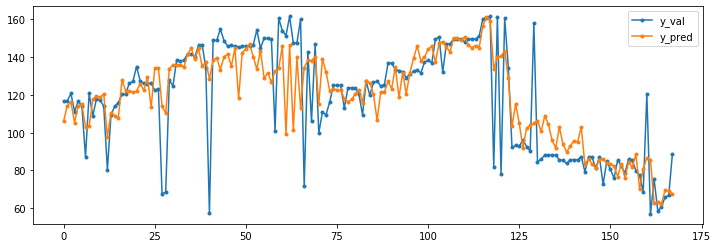

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[36]	valid_0's l1: 10.3757	valid_0's l2: 272.747


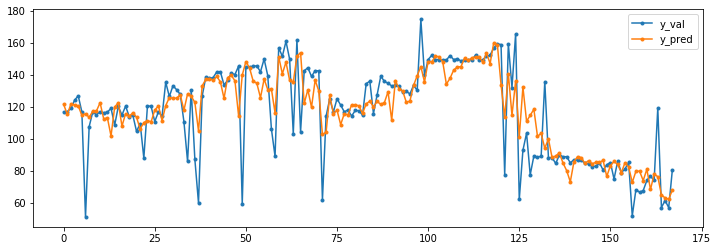

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[32]	valid_0's l1: 10.0747	valid_0's l2: 256.243


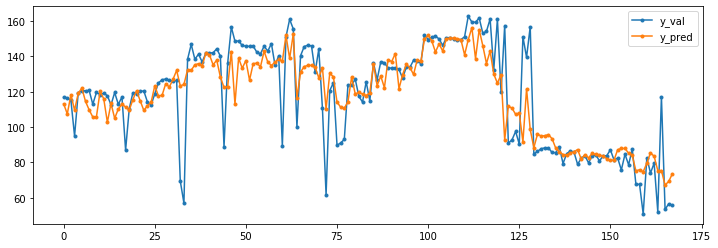

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[47]	valid_0's l1: 8.52751	valid_0's l2: 172.102


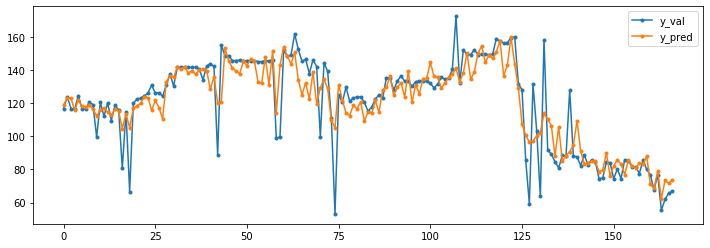

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[33]	valid_0's l1: 8.39203	valid_0's l2: 160.986


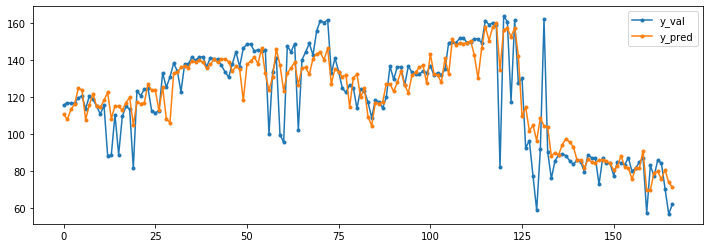

train column :  smp_max
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[17]	valid_0's l1: 15.5922	valid_0's l2: 448.878


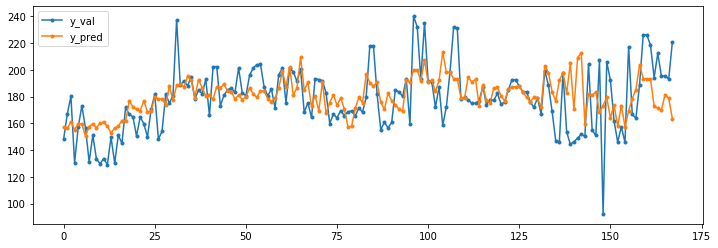

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[18]	valid_0's l1: 18.094	valid_0's l2: 848.76


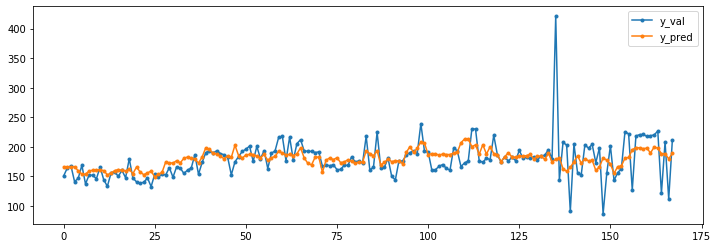

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[39]	valid_0's l1: 15.8572	valid_0's l2: 500.322


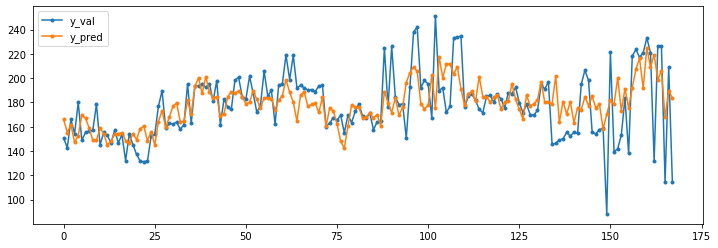

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[19]	valid_0's l1: 16.5157	valid_0's l2: 1474.45


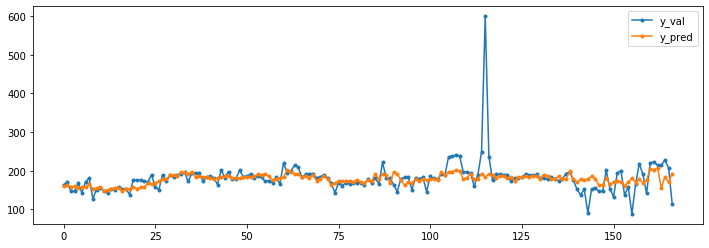

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[26]	valid_0's l1: 15.3192	valid_0's l2: 416.596


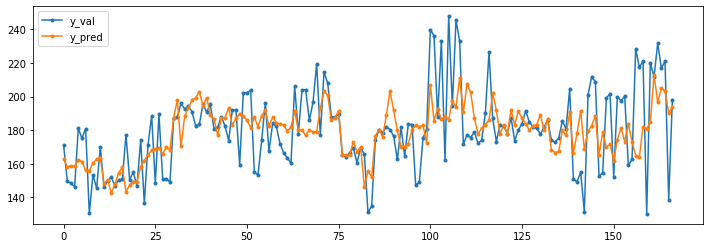

train column :  smp_mean
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[104]	valid_0's l1: 7.67672	valid_0's l2: 143.917


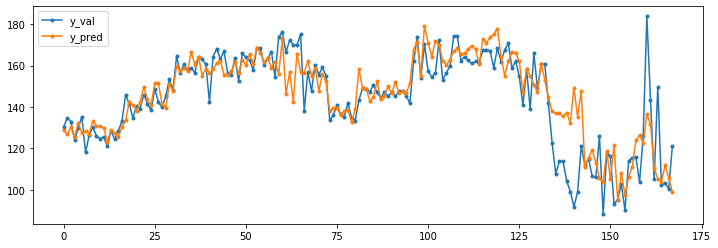

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[25]	valid_0's l1: 7.342	valid_0's l2: 126.85


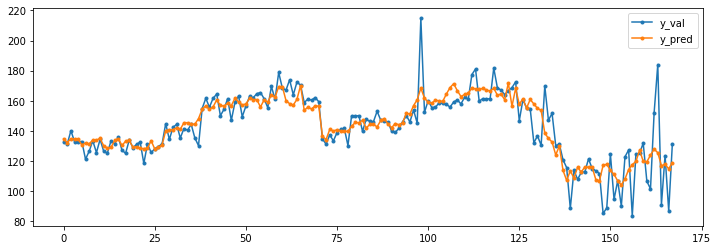

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[49]	valid_0's l1: 7.82805	valid_0's l2: 146.46


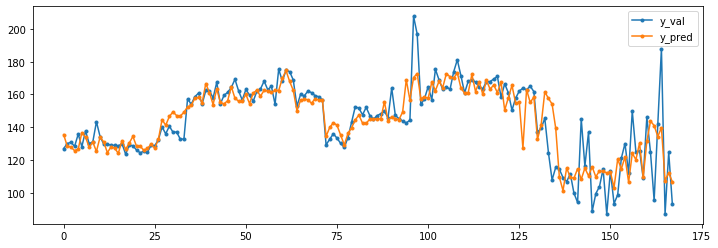

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[44]	valid_0's l1: 6.41035	valid_0's l2: 97.3785


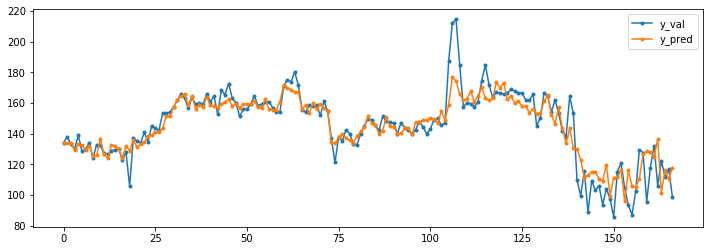

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[73]	valid_0's l1: 6.22579	valid_0's l2: 90.2326


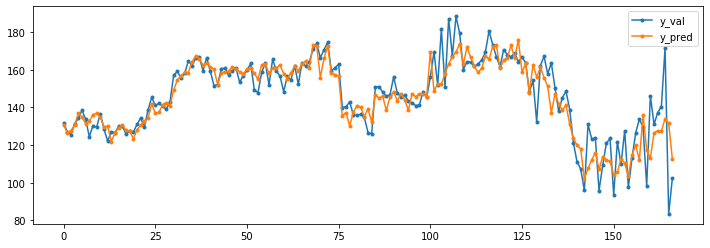

In [48]:
x_train = target.loc[:, ['supply', 'year', 'month', 'day', 'dayofweek', 'temp_max', 'temp_min', 'temp_mean']]
y_train = target.loc[:, ['smp_min', 'smp_max', 'smp_mean' ]]
scores_l1 = []
scores_l2 = []

smp_models = {}
for label in y_train.columns:
    print('train column : ', label)
    smp_models[label], scores = create_model(x_train, y_train[label])
    
    scores_l1.append(scores[0])
    scores_l2.append(scores[1])
    print('==========================================================================')

In [49]:
print(sum(scores_l1) / len(scores_l1))
print(sum(scores_l2) / len(scores_l2))

11.01924023694768
363.278425653489


In [50]:
x_test = test.loc[:,['supply', 'year', 'month', 'day', 'dayofweek', 'temp_max', 'temp_min', 'temp_mean']]
for label in ['smp_min', 'smp_max', 'smp_mean']:
    preds = []
    for i in range(5):
        preds.append(smp_models[label][i].predict(x_test))
    pred = sum(preds)/len(preds)
    test[label] = pred

In [51]:
submission.loc[:, ['smp_min', 'smp_max', 'smp_mean', 'supply']] = test.loc[:,['smp_min', 'smp_max', 'smp_mean', 'supply']]
submission = pd.concat([submission, submission_bottom_half], axis = 0)
submission

,date,smp_max,smp_min,smp_mean,supply
0,2020-02-07,158.683285,74.493727,100.810654,64.315810
1,2020-02-08,150.678654,73.237097,99.278793,65.149270
2,2020-02-09,151.648346,72.641939,99.464398,66.548393
3,2020-02-10,160.433351,75.812027,102.825994,65.934107
4,2020-02-11,172.880567,76.653541,103.194041,65.663350
5,2020-02-12,171.750122,76.358806,101.909723,63.208835
6,2020-02-13,171.977118,76.933654,101.240970,64.017574
7,2020-02-14,172.480689,76.685596,101.069162,66.422874
8,2020-02-15,166.363902,76.554012,99.627816,66.865894
9,2020-02-16,168.408059,75.854496,100.543430,66.486423


In [52]:
submission.to_csv('Dacon_baseline_v2.csv', index=False)